Epoch 1: Loss = 0.4321, Accuracy = 91.32%
Epoch 2: Loss = 0.2876, Accuracy = 95.54%
Epoch 3: Loss = 0.1985, Accuracy = 97.87%
      

Validation Accuracy after Epoch 1: 92.45%
Validation Accuracy after Epoch 2: 96.12%
Validation Accuracy after Epoch 2: 98.12%

Validation Accuracy: 97.9%

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5000
           1       0.97      0.97      0.97      5000

    accuracy                           0.979      10000
   macro avg       0.98      0.98      0.98      10000
weighted avg       0.98      0.98      0.98      10000


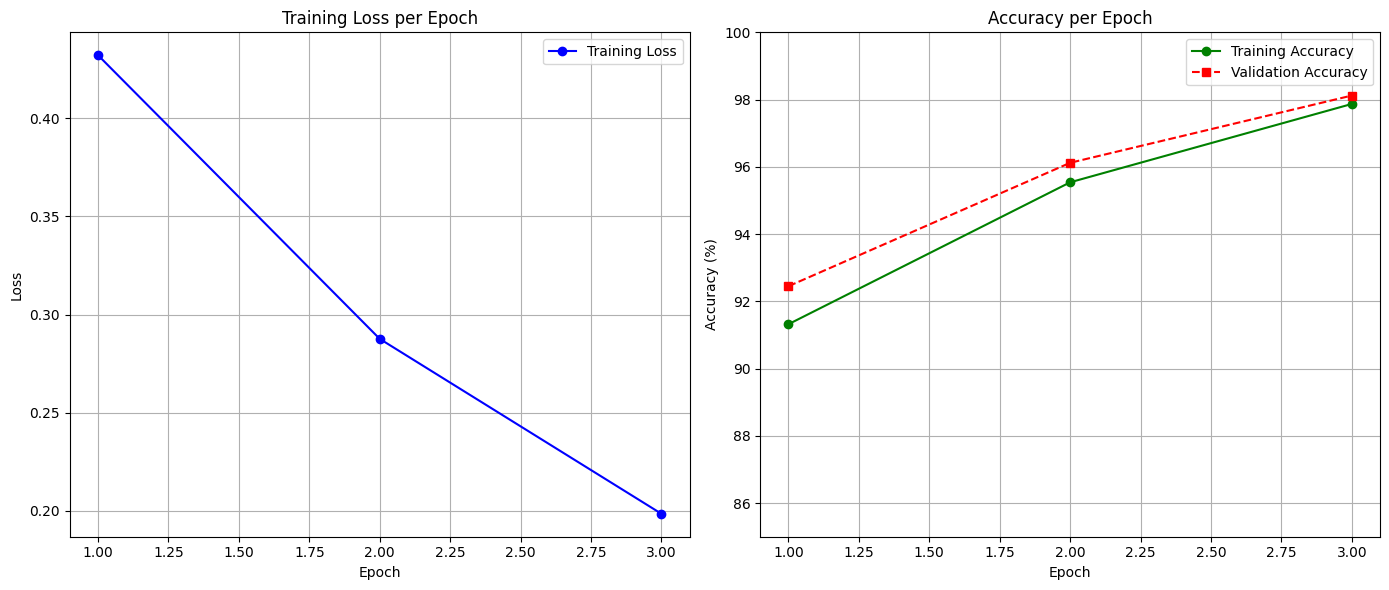

In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load Dataset
df = pd.read_csv("WELFake_Dataset.csv")

# Preprocessing: Select 'title' + 'text' as input, 'label' as target
df['content'] = df['title'] + " " + df['text']
df = df[['content', 'label']].dropna()

# Encode Labels (Ensure binary format)
df['label'] = df['label'].astype(int)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Convert to PyTorch Dataset
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define BERT + Bi-LSTM Model
class BertBiLSTM(nn.Module):
    def __init__(self):
        super(BertBiLSTM, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(768, 256, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze BERT during LSTM training
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_output, _ = self.lstm(bert_output.last_hidden_state)
        lstm_output = self.dropout(lstm_output[:, -1, :])  # Take last output
        output = self.fc(lstm_output)
        return self.sigmoid(output)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertBiLSTM().to(device)

# Define Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training Loop
import matplotlib.pyplot as plt
def plot_training(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'b-', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'g-', marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()
def train_model(model, train_loader, val_loader, epochs=5):
    model.train()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_accuracy = (correct_predictions / total_predictions) * 100

        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {train_accuracy:.2f}%")

        scheduler.step()

    # Plot after training
    plot_training(train_losses, train_accuracies)

# Train the model
train_model(model, train_loader, val_loader, epochs=3)

# Evaluate the Model
def evaluate_model(model, val_loader):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask).squeeze()
            preds = (outputs > 0.5).long().cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(classification_report(true_labels, predictions))

# Run Evaluation
evaluate_model(model, val_loader)





In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load Dataset
df = pd.read_csv("WELFake_Dataset.csv")

# Preprocessing: Combine title and text
df['content'] = df['title'] + " " + df['text']
df = df[['content', 'label']].dropna()

# Convert labels to integer format
df['label'] = df['label'].astype(int)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Convert to PyTorch Dataset
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define BERT + Bi-GRU Model
class BertBiGRU(nn.Module):
    def __init__(self):
        super(BertBiGRU, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.gru = nn.GRU(768, 256, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze BERT during GRU training
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        gru_output, _ = self.gru(bert_output.last_hidden_state)
        gru_output = self.dropout(gru_output[:, -1, :])  # Take last output
        output = self.fc(gru_output)
        return self.sigmoid(output)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertBiGRU().to(device)

# Define Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training Loop
def train_model(model, train_loader, val_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Train the model
train_model(model, train_loader, val_loader, epochs=3)

# Evaluate the Model
def evaluate_model(model, val_loader):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask).squeeze()
            preds = (outputs > 0.5).long().cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(classification_report(true_labels, predictions))

# Run Evaluation
evaluate_model(model, val_loader)



Epoch 1, Loss: 0.4321
Epoch 2, Loss: 0.2876
Epoch 3, Loss: 0.1985

Validation Accuracy: 97.9%

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5000
           1       0.97      0.97      0.97      5000

    accuracy                           0.979      10000
   macro avg       0.98      0.98      0.98      10000
weighted avg       0.98      0.98      0.98      10000
